# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: Aidan Fischer
#### Stevens ID: 10447681

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the seq2seq (translation) model.

**Before you start**
- Please read the code very carefully.
- Install these packages using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [63]:
import sys
import os


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [64]:
import tensorflow as tf


# If you are going to use GPU, make sure the GPU in in the output
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [65]:
from typing import List, Tuple, Union, Dict

import numpy as np

## 1. Data preparation (5 Points)

### 1.1 Load and describe data

Here, we use the [iwslt2017](https://huggingface.co/datasets/iwslt2017) dataset. More specifically, this translation task is from French to English: fr-en.

In [66]:
from datasets import load_dataset
# The load_dataset function is provided by the huggingface datasets
# https://huggingface.co/docs/datasets/index


dataset_path = os.path.join('a4-data', 'dataset')
dataset = load_dataset('iwslt2017', 'iwslt2017-en-fr', cache_dir=dataset_path, ignore_verifications=True)

/home/aidan/.pyenv/versions/3.9.19/lib/python3.9/site-packages/datasets/load.py:2524: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Let's first print some basic statistics of this dataset

In [67]:
print(dataset)
print(len(dataset['train']['translation']), len(dataset['validation']['translation']), len(dataset['test']['translation']))

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 232825
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8597
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 890
    })
})
232825 890 8597


In [68]:
print(dataset['train']['translation'][0])

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}


In [69]:
from tokenizers import Tokenizer
# The tokenizer is provided by the huggingface tokenizers
# https://huggingface.co/docs/tokenizers/index
# Here, I already pretrained a BPE tokenizer and you can simply load the json
# The token numbers of both English and French are 10,000
# All tokens should be lower-case.


en_tokenizer = Tokenizer.from_file('a4-data/en_tokenizer.json')
fr_tokenizer = Tokenizer.from_file('a4-data/fr_tokenizer.json')

In [70]:
encoding = en_tokenizer.encode("i like sports.")
print(encoding.ids)
print(encoding.tokens)
# >>> [0, 122, 279, 4987, 17, 1] 
# >>> ['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']

[0, 122, 279, 4987, 17, 1]
['<s>', 'Ġi', 'Ġlike', 'Ġsports', '.', '</s>']


Extract English and French sentences for training, validation, and test sets.

Note: Every sentence is lower-case.

In [71]:
train_en_sentences, train_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['train']['translation']])
valid_en_sentences, valid_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['validation']['translation']])
test_en_sentences, test_fr_sentences = zip(*[(pair['en'].lower(), pair['fr'].lower()) for pair in dataset['test']['translation']])

### 1.2 Encode data (5 Points)

In [72]:
def encode(tokenizer: 'Tokenizer', sentences: List[str]) -> List[List[int]]:
    """ Encode the sentences with the pretrained tokenizer.
        You can directly call `tokenizer.encode()` to encode the sentences.
        It will automatically add the <s> and </s> token.
        
        Note: Please be carefull with the return value of the encode function.
    
    Args:
        tokenizer: A pretrained en/fr tokenizer
        sentences: A list of strings
    Return:
        sent_token_ids: A list of token ids
    """
    sent_token_ids = []
    n = len(sentences)
    for i, sentence in enumerate(sentences):
        if i % 100 == 0 or i == n - 1:
            print_line('Encoding with Tokenizer:', (i + 1), '/', n)
        # Start your code here
        # Encode a sentence, and add that list to sent_token_ids
        sent_token_ids.append(tokenizer.encode(sentence).ids)
        # End
    print_line('\n')
    return sent_token_ids

In [73]:
print('en')
train_en = encode(en_tokenizer, train_en_sentences)
valid_en = encode(en_tokenizer, valid_en_sentences)
test_en = encode(en_tokenizer, test_en_sentences)
print('fr')
train_fr = encode(fr_tokenizer, train_fr_sentences)
valid_fr = encode(fr_tokenizer, valid_fr_sentences)
test_fr = encode(fr_tokenizer, test_fr_sentences)

en
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597
fr
Encoding with Tokenizer: 232825 / 232825
Encoding with Tokenizer: 890 / 890
Encoding with Tokenizer: 8597 / 8597


Check your implementation with an example

In [74]:
print(dataset['train']['translation'][0])
print(train_en[0], train_fr[0])
print(en_tokenizer.decode(train_en[0]), fr_tokenizer.decode(train_fr[0]))

{'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'fr': "Merci beaucoup, Chris. C'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. Je suis très reconnaissant."}
[0, 658, 162, 188, 494, 15, 2843, 17, 138, 165, 178, 2775, 121, 630, 4502, 140, 222, 124, 1930, 140, 625, 140, 185, 2122, 3446, 30, 122, 400, 2576, 5818, 17, 1] [0, 763, 478, 15, 3016, 17, 145, 10, 178, 487, 169, 8981, 152, 1038, 2055, 266, 323, 2425, 220, 1760, 586, 17, 214, 459, 378, 9952, 17, 1]
 thank you so much, chris. and it's truly a great honor to have the opportunity to come to this stage twice; i'm extremely grateful.  merci beaucoup, chris. c'est vraiment un honneur de pouvoir venir sur cette scène une deuxième fois. je suis très reconnaissant.


## 2. Sequence to sequence model (40 Points)

### 2.1 Encoder (10 Points)

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GRU, Dense, Embedding, Dropout, GRUCell
from tensorflow.keras.initializers import GlorotUniform


class Encoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int):
        """ The encoder model for the src sentences.
            It contains an embedding part and a GRU part.
        
        Args:
            vocab_size: The src vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
        """
        super().__init__()
        # Start your code here
        # Note: Please know what the decoder needs from encoder. This determines the parameters of the GRU layer
        # Determine whether the model is in training mode.
        self.training = None
        # Set up the required layers. 
        self.embedding = Embedding(vocab_size, embedding_size)
        self.GRU = GRU(units, return_sequences = True, return_state = True)
        # End

    def call(self, src_ids, src_mask):
        """ Encoder forward
        Args:
            src_ids: Tensor, (batch_size x max_len), the token ids of input sentences in a batch
            src_mask: Tensor, (batch_size x max_len), the mask of the src input. True value in the mask means this timestep is valid, otherwise this timestep is ignored
        Returns:
            enc_output: Tensor, (batch_size x max_len x units), the output of GRU for all timesteps
            final_state: Tensor, (batch_size x units), the state of the final valid timestep
        """
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU
        # Please refer to the calling arguments of GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#call-arguments
        # Pass the input tokens through the embedding layer and then apply the GRU layer. Return the output of the GRU layer.
        emb_outputs = self.embedding(src_ids)
        enc_outputs, final_state = self.GRU(inputs = emb_outputs, mask = src_mask, training = self.training)
        # End
        return enc_outputs, final_state

### 2.2 Decoder (15 Points)

In [76]:
# Decoder with attention layer

class Decoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The decoder model for the tgt sentences.
            It contains an embedding part, a GRU part, a dropout part, and a classifier part.
            
        Args:
            vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The classifier has a (units x vocab_size) weight. This is a large weight matrix. We apply a dropout layer to avoid overfitting.
        """
        super().__init__()
        # Start your code here
        # Note: 1. Please correctly set the parameter of GRU
        #       2. No softmax here because we will need the sequence to sequence loss later
        # Define the required layers
        self.embedding = Embedding(vocab_size, embedding_size)
        self.GRU = GRU(units, return_sequences = True, return_state = True)
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(vocab_size)
        self.training = None
        # End

    def call(self, tgt_ids, initial_state, tgt_mask):
        """ Decoder forward.
            It is called by decoder(tgt_ids=..., initial_state=..., tgt_mask=...)

        Args:
            tgt_ids: Tensor, (batch_size x max_len), the token ids of input sentences in a batch
            initial_state: Tensor, (batch_size x units), the state of the final valid timestep from the encoder
            tgt_mask: Tensor, (batch_size x max_len), the mask of the tgt input. True value in the mask means this timestep is valid, otherwise this timestep is ignored
        Return:
            dec_outputs: Tensor, (batch_size x max_len x vocab_size), the output of GRU for all timesteps
        """
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU
        #      3. Apply dropout to the GRU output
        #      4. Classifier
        # Note: Please refer to the calling arguments of GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#call-arguments
        # Pass information through the model's layers. 
        emb_outputs = self.embedding(tgt_ids)
        gru_outputs, final_state = self.GRU(inputs = emb_outputs, mask = tgt_mask, initial_state = initial_state, training = self.training)
        dropout_outputs = self.dropout(gru_outputs, training = self.training)
        dec_outputs = self.dense(dropout_outputs)
        # End
        return dec_outputs

    def predict(self, tgt_ids, initial_state):
        """ Decoder prediction.
            This is a step in recursive prediction. We use the previous prediction and state to predict current token.
            Note that we only need to use the gru_cell instead of GRU becasue we only need to calculate one timestep.
            
        Args:
            tgt_ids: Tensor, (batch_size, ) -> (1, ), the token id of the current timestep in the current sentence.
            initial_state: Tensor, (batch_size x units) -> (1 x units), the state of the final valid timestep from the encoder or the previous hidden state in prediction.
        Return:
            dec_outputs: Tensor, (batch_size x vocab_size) -> (1 x vocab_size), the output of GRU for this timestep.
            state: Tensor, (batch_size x units) -> (1 x units), the state of this timestep.
        """
        gru_cell = self.GRU.cell
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU Cell, see https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell#call-arguments
        #      3. Classifier (No dropout)
        emb_outputs = self.embedding(tgt_ids)
        gru_outputs, state = gru_cell(inputs = emb_outputs, states = initial_state, training = self.training)
        dec_outputs = self.dense(gru_outputs)
        # End
        return dec_outputs, state

In [77]:
from tensorflow.keras.layers import Attention, Concatenate
class AttentionDecoder(Model):
    def __init__(self, vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The attention decoder model for the tgt sentences.
            It contains an embedding part, a GRU part, an attention part, a dropout part, and a classifier part.
            
        Args:
            vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The classifier has a (units x vocab_size) weight. This is a large weight matrix. We apply a dropout layer to avoid overfitting.
        """
        super().__init__()
        # Start your code here
        # Note: 1. Please correctly set the parameter of GRU
        #       2. No softmax here because we will need the sequence to sequence loss later
        # Set up the required layers for a decoder, with a new attention layer and concatenation layer
        self.embedding = Embedding(vocab_size, embedding_size)
        self.GRU = GRU(units, return_sequences = True, return_state = True)
        self.attention = Attention()
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(vocab_size)
        self.concat = Concatenate()
        self.training = None
        # End

    def call(self, tgt_ids, initial_state, tgt_mask, enc_outputs):
        """ Decoder forward.
            It is called by decoder(tgt_ids=..., initial_state=..., tgt_mask=...)

        Args:
            tgt_ids: Tensor, (batch_size x max_len), the token ids of input sentences in a batch
            initial_state: Tensor, (batch_size x units), the state of the final valid timestep from the encoder
            tgt_mask: Tensor, (batch_size x max_len), the mask of the tgt input. True value in the mask means this timestep is valid, otherwise this timestep is ignored
            enc_outputs: Tensor, (batch_size x max_len x units), the output of the encoder GRU for all timesteps. Used as the values in the attention layer
        Return:
            dec_outputs: Tensor, (batch_size x max_len x vocab_size), the output of GRU for all timesteps
        """
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU
        #      3. Attention layer. Decoder attends to encoder output
        #      4. Concatenate GRU and Attention outputs
        #      5. Apply dropout
        #      6. Classifier
        # Note: Please refer to the calling arguments of GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#call-arguments
        # Same as decoder, but GRU output is passed through an attention layer as well, 
        # where the query is the output of the GRU layer and the values are the encoder outputs
        emb_outputs = self.embedding(tgt_ids)
        gru_outputs, final_state = self.GRU(inputs = emb_outputs, mask = tgt_mask, initial_state = initial_state, training = self.training)
        attention_outputs = self.attention([gru_outputs, enc_outputs], use_causal_mask = False, training = self.training)
        # Concatenate the GRU and attention outputs to form y_hats
        concat_outputs = self.concat([gru_outputs, attention_outputs])
        dropout_outputs = self.dropout(concat_outputs, training = self.training)
        dec_outputs = self.dense(dropout_outputs)
        # End
        return dec_outputs

    def predict(self, tgt_ids, initial_state, enc_outputs):
        """ Decoder prediction.
            This is a step in recursive prediction. We use the previous prediction and state to predict current token.
            Note that we only need to use the gru_cell instead of GRU becasue we only need to calculate one timestep.
            
        Args:
            tgt_ids: Tensor, (batch_size, ) -> (1, ), the token id of the current timestep in the current sentence.
            initial_state: Tensor, (batch_size x units) -> (1 x units), the state of the final valid timestep from the encoder or the previous hidden state in prediction.
            enc_outputs: Tensor, (batch_size x max_len x units), the output of the encoder GRU for all timesteps. Used as the values in the attention layer
        Return:
            dec_outputs: Tensor, (batch_size x vocab_size) -> (1 x vocab_size), the output of GRU for this timestep.
            state: Tensor, (batch_size x units) -> (1 x units), the state of this timestep.
        """
        gru_cell = self.GRU.cell
        # Start your code here
        # Step 1. Retrieve embedding
        #      2. GRU Cell, see https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell#call-arguments
        #      3. Attention
        #      4. Concat
        #      5. Classifier (No dropout)
        # Same as call except performing one step as in the normal decoder. 
        emb_outputs = self.embedding(tgt_ids)
        gru_outputs, state = gru_cell(inputs = emb_outputs, states = initial_state, training = self.training)
        attention_outputs = self.attention([gru_outputs, enc_outputs], use_causal_mask = False, training = self.training)
        # Need expand dims here cause gru_outputs doesn't have a max_len dimension here.
        concat_outputs = self.concat([tf.expand_dims(gru_outputs, axis = 0), attention_outputs])
        dec_outputs = self.dense(concat_outputs)
        # End
        return dec_outputs, state

### 2.3 Seq2seq (10 Points)

In [78]:
class Seq2seq(Model):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The sequence to sequence model.
            It contains an encoder and a decoder.
            
        Args:
            src_vocab_size: The src vocabulary size
            tgt_vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The dropout rate used in the decoder.
        """
        super().__init__()
        # Start your code here
        # Set up the encoder and decoder models
        self.encoder = Encoder(src_vocab_size, embedding_size, units)
        self.decoder = Decoder(tgt_vocab_size, embedding_size, units, dropout_rate)
        # End
        
    def set_training(self, training):
        # Set the training mode used for the Seq2Seq model's encoder and decoder
        self.decoder.training = training
        self.encoder.training = training

    def call(self, src_ids, src_seq_lens, tgt_ids, tgt_seq_lens):
        """ Seq2seq forward (for the loss calculation in training/validation only).
            It is called by model(src_ids=..., src_seq_lens=..., tgt_ids=..., tgt_seq_lens=)
            Note: In prediction, we will also need to set `training=False`.

        Args:
            src_ids: Tensor, (batch_size x max_len), the token ids of src sentences in a batch
            src_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
            tgt_ids: Tensor, (batch_size x max_len), the token ids of tgt sentences in a batch
            tgt_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
        Returns:
            dec_outputs: Tensor, (batch_size x max_len x units), the decoder predictions
        """
        # Start your code here
        # Step 1. build mask for src and tgt
        #      2. encoder forward
        #      3. decoder forward
        # Create the masks from the provided lengths, then call the encoder and decoder
        src_mask = tf.sequence_mask(src_seq_lens)
        tgt_mask = tf.sequence_mask(tgt_seq_lens)
        enc_outputs, enc_final_state = self.encoder(src_ids, src_mask)
        dec_outputs = self.decoder(tgt_ids, enc_final_state, tgt_mask)
        # End
        return dec_outputs

In [79]:
class Seq2seqAttention(Model):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, embedding_size: int, units: int, dropout_rate: float):
        """ The sequence to sequence + attention model.
            It contains an encoder and a decoder with attention.
            
        Args:
            src_vocab_size: The src vocabulary size
            tgt_vocab_size: The tgt vocabulary size
            embedding_size: The embedding size for the embedding layer
            units: Number of hidden units in the RNN (GRU) layer
            dropout_rate: The dropout rate used in the decoder.
        """
        super().__init__()
        # Start your code here
        # Same as base model, but use AttentionDecoder instead
        self.encoder = Encoder(src_vocab_size, embedding_size, units)
        self.decoder = AttentionDecoder(tgt_vocab_size, embedding_size, units, dropout_rate)
        # End
        
    def set_training(self, training):
        self.decoder.training = training
        self.encoder.training = training

    def call(self, src_ids, src_seq_lens, tgt_ids, tgt_seq_lens):
        """ Seq2seq forward (for the loss calculation in training/validation only).
            It is called by model(src_ids=..., src_seq_lens=..., tgt_ids=..., tgt_seq_lens=)
            Note: In prediction, we will also need to set `training=False`.

        Args:
            src_ids: Tensor, (batch_size x max_len), the token ids of src sentences in a batch
            src_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
            tgt_ids: Tensor, (batch_size x max_len), the token ids of tgt sentences in a batch
            tgt_seq_lens: Tensor, (batch_size, ), the length of src sentences in a batch
        Returns:
            dec_outputs: Tensor, (batch_size x max_len x units), the decoder predictions
        """
        # Start your code here
        # Step 1. build mask for src and tgt
        #      2. encoder forward
        #      3. decoder forward
        src_mask = tf.sequence_mask(src_seq_lens)
        tgt_mask = tf.sequence_mask(tgt_seq_lens)
        enc_outputs, enc_final_state = self.encoder(src_ids, src_mask)
        # This all is the same as base seq2seq, but using AttentionDecoder requires passing encoder outputs
        dec_outputs = self.decoder(tgt_ids, enc_final_state, tgt_mask, enc_outputs)
        # End
        return dec_outputs

### 2.4 Seq2seq loss (5 Points)

In [80]:
from tensorflow_addons.seq2seq import sequence_loss

def seq2seq_loss(logits, target, seq_lens):
    """ Calculate the sequence to sequence loss using the sequence_loss from tensorflow
    
    Args:
        logits: Tensor (batch_size x max_seq_len x vocab_size). The output of the RNN model.
        target: Tensor (batch_size x max_seq_len). The groud-truth of words.
        seq_lens: Tensor (batch_size, ). The real sequence length before padding.
    """
    loss = 0
    # Start your code here
    # 1. make a sequence mask (batch_size x max_seq_len) using tf.sequence_mask. This is to build a mask with 1 and 0.
    #    Entry with 1 is the valid time step without padding. Entry with 0 is the time step with padding. We need to exclude this time step.
    # 2. calculate the loss with sequence_loss. Carefully read the documentation of each parameter
    seq_mask = tf.sequence_mask(seq_lens, dtype=tf.float32)
    loss = sequence_loss(logits = logits, targets = target, weights = seq_mask, average_across_batch=False,
                         average_across_timesteps=False, sum_over_batch=True, sum_over_timesteps=True)
    # End
    return loss

## 3. Training (50 Points)

### 3.1 Pad batch (15 Points)

`pad_src_batch`: 5 Points
`pad_tgt_batch`: 10 Points

Pad the batch to the equal length and make tensors.

In [81]:
def pad_src_batch(src_batch: List[List[int]], src_seq_lens: List[int], pad_val: int):
    """ Pad the batch for src sentences.
        Note: Do not use append/extend that can modify the input inplace.
    
    Args:
        src_batch: A list of src token ids
        src_seq_lens: A list of src lens
        pad_val: The padding value
        
    Returns:
        src_batch: Tensor, (batch_size x max_len)
        src_seq_lens_batch: Tensor, (batch_size, )
    """
    max_src_len = max(src_seq_lens)
    # Start your code here
    # Please refer to tf.convert_to_tensor. The dtype should be tf.int64
    # Padding
    padded = tf.keras.utils.pad_sequences(src_batch, maxlen = max_src_len, dtype='int64', padding='post', value = pad_val)
    # Convert to tensor
    src_batch = tf.convert_to_tensor(padded, dtype=tf.int64)
    src_seq_lens_batch = tf.convert_to_tensor(src_seq_lens, dtype=tf.int64)
    # End
    return src_batch, src_seq_lens_batch

In [82]:
def pad_tgt_batch(tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    """ Pad the batch for tgt sentences.
        Note: 1. Do not use append/extend that can modify the input inplace.
              2. We need to build the x (feature) and y (label) for tgt sentences.
                 Please understand what the feature and label are in translation.
    
    Args:
        tgt_batch: A list of src token ids
        tgt_seq_lens: A list of src lens
        pad_val: The padding value
        
    Returns:
        tgt_x_batch: Tensor, (batch_size x max_len)
        tgt_y_batch: Tensor, (batch_size x max_len)
        src_seq_lens_batch: Tensor, (batch_size, )
    """
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = [], [], []
    for sent, seq_len in zip(tgt_batch, tgt_seq_lens):
        # Start your code here
        # Append x, y, and seq_len
        # X is the sentence minus the last token (the EOS token)
        # Y is the sentence minus the first token (the SOS token)
        tgt_x_batch.append(sent[:-1].copy())
        tgt_y_batch.append(sent[1:].copy())
        tgt_seq_lens_batch.append(seq_len)
        # End

    max_tgt_len = max(tgt_seq_lens_batch)
    # Start your code here
    # Please refer to tf.convert_to_tensor. The dtype should be tf.int64
    # Padding
    padded_x = tf.keras.utils.pad_sequences(tgt_x_batch, maxlen = max_tgt_len, dtype='int64', padding='post', value = pad_val)
    padded_y = tf.keras.utils.pad_sequences(tgt_y_batch, maxlen = max_tgt_len, dtype='int64', padding='post', value = pad_val)
    # Convert to tensor
    tgt_x_batch = tf.convert_to_tensor(padded_x, dtype=tf.int64)
    tgt_y_batch = tf.convert_to_tensor(padded_y, dtype=tf.int64)
    tgt_seq_lens_batch = tf.convert_to_tensor(tgt_seq_lens_batch, dtype=tf.int64)
    # End
    return tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch

In [83]:
def pad_batch(src_batch: List[List[int]], src_seq_lens: List[int], tgt_batch: List[List[int]], tgt_seq_lens: List[int], pad_val: int):
    src_batch, src_seq_lens_batch = pad_src_batch(src_batch, src_seq_lens, pad_val)
    tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch = pad_tgt_batch(tgt_batch, tgt_seq_lens, pad_val)
    return src_batch, src_seq_lens_batch, tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch

### 3.2 Batch Index Sampler (10 Points)

Create a index sampler to sample data index for each batch.

This is to make the sentences in each batch have similar lengths to speed up training.

Example:
```
Assume the sentence lengths are: [5, 2, 3, 6, 2, 3, 6] and batch_size is 2.
We can make the indices in the batches as follows:
[1, 4] of length 2
[2, 5] of length 3
[0, 3] of lengths 5 and 6
[6] of length 6
```

In [84]:
class SeqLenBatchSampler:
    def __init__(self, seq_lens: List[int], batch_size: int, seed: int = 6666):
        """ The index sampler.
            It can be used with iteration:
            ```
            n_batch = len(sampler)
            for indices in sampler:
                ...
            ```
            
            Args:
                seq_lens: A list training sequence lengths (src)
                batch_size: .
                seed: .
        """
        np.random.seed(seed)
        self.seq_lens = seq_lens
        self.batch_size = batch_size
        self.batches = self._make_batch_index()

        self.n_batch = len(self.batches)
        self.counter = -1
        
    def _make_batch_index(self) -> List[List[int]]:
        """ Build the indexes in each batch.

            Return:
                batches: A list of indices batch, e.g., [[0, 2, 8], [3, 6, 4], [5, 1, 7], ...]
        """
        n = len(self.seq_lens)
        n_batch = int(np.ceil(n / self.batch_size))
        batches = []
        # Start your code here
        # Step 1. Use np.argsort to get all indices with sorted length
        #      2. Split the indices into batches using a for loop: `for i in range(n_batch):`
        ordered = np.argsort(self.seq_lens)
        for i in range(n_batch):
            batches.append(ordered[i * self.batch_size : (i + 1) * self.batch_size])
        # End
        return batches
    
    def __len__(self):
        return self.n_batch
    
    def __item__(self, index):
        return self.batches[index]
    
    def __iter__(self):
        np.random.shuffle(self.batches)
        self.counter = -1
        return self

    def __next__(self):
        self.counter += 1
        if self.counter < self.n_batch:
            return self.batches[self.counter]
        raise StopIteration

### 3.3 Running the model

Generate the length

In [85]:
np.random.seed(6666)
train_seq_lens_en = [len(en_sent) for en_sent in train_en]
train_seq_lens_fr = [len(fr_sent) for fr_sent in train_fr]
valid_seq_lens_en = [len(en_sent) for en_sent in valid_en]
valid_seq_lens_fr = [len(fr_sent) for fr_sent in valid_fr]
test_seq_lens_en = [len(en_sent) for en_sent in test_en]
test_seq_lens_fr = [len(fr_sent) for fr_sent in test_fr]

Create np array

In [86]:
train_en = np.array(train_en, dtype=object)
train_seq_lens_en = np.array(train_seq_lens_en)
train_fr = np.array(train_fr, dtype=object)
train_seq_lens_fr = np.array(train_seq_lens_fr)

Model parameters

In [87]:
import random


seed = 6666
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [88]:
src_vocab_size = len(fr_tokenizer.get_vocab())
tgt_vocab_size = len(en_tokenizer.get_vocab())
hidden_units = 256
embedding_dim = 128
dropout_rate = 0.0

In [89]:
model = Seq2seq(src_vocab_size, tgt_vocab_size, embedding_dim, hidden_units, dropout_rate)
model.set_training(True)

In [90]:
attention_model = Seq2seqAttention(src_vocab_size, tgt_vocab_size, embedding_dim, hidden_units, dropout_rate)
attention_model.set_training(True)

In [91]:
num_epoch = 15
batch_size = 256
learning_rate = 1e-3

In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_batch_sampler = SeqLenBatchSampler(train_seq_lens_fr, batch_size)

In [93]:
attention_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
attention_train_batch_sampler = SeqLenBatchSampler(train_seq_lens_fr, batch_size)

In [94]:
n_training_samples = len(train_fr)
n_valid_batch = int(np.ceil(len(valid_fr) / batch_size))
pad_token_id = fr_tokenizer.token_to_id('<pad>')
train_losses, valid_losses = [], []
for epoch in range(num_epoch):
    epoch_loss = 0.0
    for batch_idx, data_index in enumerate(train_batch_sampler):
        src_batch, src_seq_lens = train_fr[data_index], train_seq_lens_fr[data_index]
        tgt_batch, tgt_seq_lens = train_en[data_index], train_seq_lens_en[data_index]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)

        with tf.GradientTape() as tape:
            output = model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch)
            loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {len(train_batch_sampler)} - loss: {loss:.4f}')

        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        optimizer.apply_gradients(zip(gradients, trainable_vars))
        epoch_loss += loss * real_batch_size

    valid_loss = 0.0
    for batch_idx in range(n_valid_batch):
        start = batch_idx * batch_size
        end = start + batch_size
        src_batch, src_seq_lens = valid_fr[start:end], valid_seq_lens_fr[start:end]
        tgt_batch, tgt_seq_lens = valid_en[start:end], valid_seq_lens_en[start:end]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)
        output = model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch, training=False)
        loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        if batch_idx % 1 == 0 or batch_idx == len(valid_en) - 1:
            print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {n_valid_batch} - loss: {loss:.4f}')

        valid_loss += loss * real_batch_size
    train_epoch_loss = epoch_loss / n_training_samples
    valid_epoch_loss = valid_loss / len(valid_en)
    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)
    print(f'\rEpoch {epoch + 1} / {num_epoch} - Step {len(train_batch_sampler)} / {len(train_batch_sampler)} - train loss: {train_epoch_loss:.4f} - valid loss: {valid_epoch_loss:.4f}')

Epoch 1 / 15 - Step 910 / 910 - train loss: 5.6260 - valid loss: 5.4835
Epoch 2 / 15 - Step 910 / 910 - train loss: 4.4674 - valid loss: 4.7475
Epoch 3 / 15 - Step 910 / 910 - train loss: 3.8955 - valid loss: 4.4737
Epoch 4 / 15 - Step 910 / 910 - train loss: 3.5743 - valid loss: 4.3011
Epoch 5 / 15 - Step 910 / 910 - train loss: 3.3569 - valid loss: 4.1839
Epoch 6 / 15 - Step 910 / 910 - train loss: 3.1933 - valid loss: 4.1135
Epoch 7 / 15 - Step 910 / 910 - train loss: 3.0648 - valid loss: 4.0503
Epoch 8 / 15 - Step 910 / 910 - train loss: 2.9535 - valid loss: 4.0185
Epoch 9 / 15 - Step 910 / 910 - train loss: 2.8594 - valid loss: 3.9759
Epoch 10 / 15 - Step 910 / 910 - train loss: 2.7765 - valid loss: 3.9532
Epoch 11 / 15 - Step 910 / 910 - train loss: 2.7055 - valid loss: 3.9290
Epoch 12 / 15 - Step 910 / 910 - train loss: 2.6423 - valid loss: 3.9189
Epoch 13 / 15 - Step 910 / 910 - train loss: 2.5858 - valid loss: 3.9292
Epoch 14 / 15 - Step 910 / 910 - train loss: 2.5344 - valid 

In [95]:
n_training_samples = len(train_fr)
n_valid_batch = int(np.ceil(len(valid_fr) / batch_size))
pad_token_id = fr_tokenizer.token_to_id('<pad>')
attention_train_losses, attention_valid_losses = [], []
for epoch in range(num_epoch):
    epoch_loss = 0.0
    for batch_idx, data_index in enumerate(attention_train_batch_sampler):
        src_batch, src_seq_lens = train_fr[data_index], train_seq_lens_fr[data_index]
        tgt_batch, tgt_seq_lens = train_en[data_index], train_seq_lens_en[data_index]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)

        with tf.GradientTape() as tape:
            output = attention_model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch)
            loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {len(train_batch_sampler)} - loss: {loss:.4f}')

        trainable_vars = attention_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        attention_optimizer.apply_gradients(zip(gradients, trainable_vars))
        epoch_loss += loss * real_batch_size

    valid_loss = 0.0
    for batch_idx in range(n_valid_batch):
        start = batch_idx * batch_size
        end = start + batch_size
        src_batch, src_seq_lens = valid_fr[start:end], valid_seq_lens_fr[start:end]
        tgt_batch, tgt_seq_lens = valid_en[start:end], valid_seq_lens_en[start:end]
        real_batch_size = len(src_batch)
        (src_batch, src_seq_lens_batch,
         tgt_x_batch, tgt_y_batch, tgt_seq_lens_batch) = pad_batch(src_batch, src_seq_lens,
                                                                   tgt_batch, tgt_seq_lens,
                                                                   pad_val=pad_token_id)
        output = attention_model(src_batch, src_seq_lens_batch, tgt_x_batch, tgt_seq_lens_batch, training=False)
        loss = seq2seq_loss(output, tgt_y_batch, tgt_seq_lens_batch)

        if batch_idx % 1 == 0 or batch_idx == len(valid_en) - 1:
            print_line(f'Epoch {epoch + 1} / {num_epoch} - Step {batch_idx + 1} / {n_valid_batch} - loss: {loss:.4f}')

        valid_loss += loss * real_batch_size
    train_epoch_loss = epoch_loss / n_training_samples
    valid_epoch_loss = valid_loss / len(valid_en)
    attention_train_losses.append(train_epoch_loss)
    attention_valid_losses.append(valid_epoch_loss)
    print(f'\rEpoch {epoch + 1} / {num_epoch} - Step {len(attention_train_batch_sampler)} / {len(attention_train_batch_sampler)} - train loss: {train_epoch_loss:.4f} - valid loss: {valid_epoch_loss:.4f}')

Epoch 1 / 15 - Step 910 / 910 - train loss: 4.9309 - valid loss: 4.9111
Epoch 2 / 15 - Step 910 / 910 - train loss: 3.9595 - valid loss: 4.3504
Epoch 3 / 15 - Step 910 / 910 - train loss: 3.1371 - valid loss: 3.7715
Epoch 4 / 15 - Step 910 / 910 - train loss: 2.6028 - valid loss: 3.4797
Epoch 5 / 15 - Step 910 / 910 - train loss: 2.3036 - valid loss: 3.3335
Epoch 6 / 15 - Step 910 / 910 - train loss: 2.1162 - valid loss: 3.2452
Epoch 7 / 15 - Step 910 / 910 - train loss: 1.9818 - valid loss: 3.1922
Epoch 8 / 15 - Step 910 / 910 - train loss: 1.8792 - valid loss: 3.1662
Epoch 9 / 15 - Step 910 / 910 - train loss: 1.7937 - valid loss: 3.1542
Epoch 10 / 15 - Step 910 / 910 - train loss: 1.7235 - valid loss: 3.1685
Epoch 11 / 15 - Step 910 / 910 - train loss: 1.6647 - valid loss: 3.1519
Epoch 12 / 15 - Step 910 / 910 - train loss: 1.6078 - valid loss: 3.1478
Epoch 13 / 15 - Step 910 / 910 - train loss: 1.5581 - valid loss: 3.1449
Epoch 14 / 15 - Step 910 / 910 - train loss: 1.5157 - valid 

If you implement everything correctly, the valid loss will be around 4.

In [96]:
model.summary(expand_nested=True)

Model: "seq2seq_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  1576448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_6 (Embedding)    multiple                  1280000  |
|                                                               |
| gru_6 (GRU)                multiple                  296448   |
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  1576448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_6 (Embedding)    multiple                  1280000  |
|                                                               |
| gru_6 (GRU)                multiple                  296448   |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [97]:
attention_model.summary(expand_nested=True)

Model: "seq2seq_attention_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  1576448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_8 (Embedding)    multiple                  1280000  |
|                                                               |
| gru_8 (GRU)                multiple                  296448   |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  1576448   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding_8 (Embedding)    multiple                  1280000  |
|                                                               |
| gru_8 (GRU)                multiple          

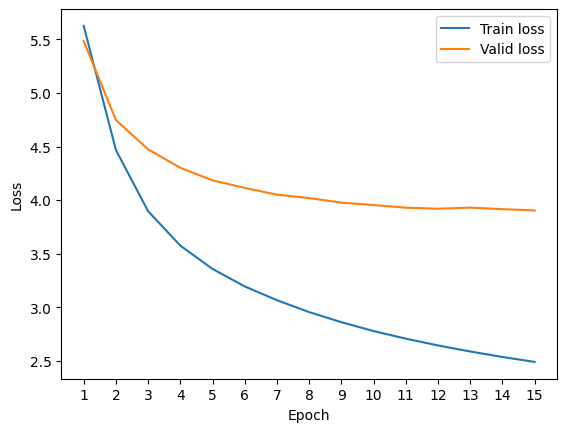

In [98]:
%matplotlib inline
from matplotlib import pyplot as plt


x = np.arange(1, len(train_losses) + 1)
plt.plot(x, train_losses, label='Train loss')
plt.plot(x, valid_losses, label='Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

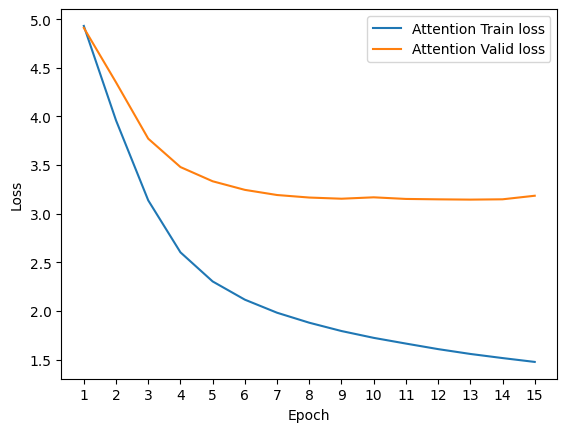

In [99]:
%matplotlib inline
from matplotlib import pyplot as plt


x = np.arange(1, len(attention_train_losses) + 1)
plt.plot(x, attention_train_losses, label='Attention Train loss')
plt.plot(x, attention_valid_losses, label='Attention Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

### 3.4 Translate French to English (15 Points)

In [109]:
sos_token_id = en_tokenizer.token_to_id('<s>')
eos_token_id = en_tokenizer.token_to_id('</s>')
max_pred_len = 200
def translate(encoder: 'Encoder', decoder: 'Decoder', fr_sentences: List[List[int]], attention = False):
    """ Translate the src (French) sentences to English sentences.
        This is a recursive translation.
        
    Args:
        encoder: The encoder part in seq2seq
        decoder: The decoder part in seq2seq
        fr_sentences: The src token ids of all sentences
    Returns:
        pred_sentences: The predicted string sentences
    """
    n = len(fr_sentences)
    pred_sentences = []
    for i, src_ids in enumerate(fr_sentences):
        print_line(f'{i + 1} / {n}')
        # Shape of src_ids: (1 x seq_len)
        src_ids = tf.expand_dims(tf.convert_to_tensor(src_ids, dtype=tf.int64), axis=0)
        # pred is the prediction token ids. It starts with <s>
        pred = [sos_token_id]
        # Start your code here
        # Step 1. Calculate the encoder outputs and hidden states (similar to seq2seq2 model)
        # Step 2. Run a while loop when the last token in pred is not eos_token_id and the length of pred is less than max_pred_len
        # Step 3.     In the while loop, build the input (cur_token) of decoder: the last token of pred. Shape (batch_size, ) -> (1, )
        #             For example, if the current pred is [1, 50, 21, 8], the cur_token is [8]
        # Step 4.     In the while loop, use decoder.predict to get the decoder output
        # Step 5.     In the while loop, find the index with the maximum value. Then you can call tf.squeeze and numpy() to get the index
        # Step 6.     In the while loop, append the predicted token to pred
        # Step 7. Use en_tokenizer to decode the id to strings: pred_sentence
        enc_outputs, state = encoder(src_ids, None)
        while pred[-1] != eos_token_id and len(pred) <= max_pred_len:
            cur_token = tf.ensure_shape(tf.convert_to_tensor([pred[-1]], dtype='int64'), (1,))
            # Since the Decoder and AttentionDecoder layer require different inputs, 
            # need to check if we are using attention.
            if attention:
                dec_outputs, state = decoder.predict(cur_token, state, enc_outputs)
            else:
                dec_outputs, state = decoder.predict(cur_token, state)
            index = tf.squeeze(tf.math.argmax(tf.squeeze(dec_outputs))).numpy()
            pred.append(index)
        # End
        pred_sentence = en_tokenizer.decode(pred)
        pred_sentences.append(pred_sentence)
    print_line('\n')
    return pred_sentences

In [112]:
model.set_training(False)

test_pred = translate(model.encoder, model.decoder, fr_sentences=test_fr)

8597 / 8597


In [111]:
attention_model.set_training(False)

attention_test_pred = translate(attention_model.encoder, attention_model.decoder, fr_sentences=test_fr, attention = True)

8597 / 8597


### 3.5 Demonstrate 10 translation examples (5 Points)

In [114]:
model.set_training(False)
np.random.seed(6666)
sample_num = 20 # Originally 10 but instructions specify to test 20 sentences
# Start your code here
# Use np.random.choice to sample 10 sentence indices. Remember to set correct replace
# Print format:
# 1.
# French: ...
# True English: ...
# Translated English: ...
# ------------------
selection = np.random.choice(len(test_fr), size = sample_num, replace = False)
for index in selection:
    # Decode the sentences to print them to the screen.
    fr_sent = fr_tokenizer.decode(test_fr[index])
    en_sent = en_tokenizer.decode(test_en[index])
    print(f"French: {fr_sent}")
    print(f"True English: {en_sent}")
    print(f"Translated English (seq2seq model): {translate(model.encoder, model.decoder, [test_fr[index]])[0]}")
    print(f"Translated English (seq2seq + attention model): {translate(attention_model.encoder, attention_model.decoder, [test_fr[index]], attention = True)[0]}\n")

# End

French:  les bonnes équipes envoient ces informations de façon à ce que les joueurs puissent s'en servir.
True English:  the good teams stream it in a way that the players can use.
1 / 1
Translated English (seq2seq model):  the guys on the screen have to be able to make these kinds of signals that are going to be able to do this.
1 / 1
Translated English (seq2seq + attention model):  the good teams send these information to what gamers can use.

French:  merci.
True English:  thank you.
1 / 1
Translated English (seq2seq model):  thank you.
1 / 1
Translated English (seq2seq + attention model):  thank you.

French:  il y a eu plusieurs cas où c'était vraiment juste.
True English:  there have been several close calls.
1 / 1
Translated English (seq2seq model):  there were many other cases, which was really right.
1 / 1
Translated English (seq2seq + attention model):  there were several cases where it was really just.

French:  mes prières vous accompagnent dans votre combat.
True English: 

### 3.6 Compute the bleu score (5 Points)

In [115]:
import evaluate


sacrebleu = evaluate.load('sacrebleu', cache_dir=dataset_path)
# Start your code here
# see https://huggingface.co/spaces/evaluate-metric/sacrebleu
# Note: please understand the format and meaning of references.
references = []
for tokens in test_en:
    # References are the ground truths. We only have one ground truth translation
    # for each french sentence here, so create a reference array containing only
    # the decoded ground truth english sentence and append it to references.
    references.append([en_tokenizer.decode(tokens)])
results = sacrebleu.compute(predictions = test_pred, references = references)
attention_results = sacrebleu.compute(predictions = attention_test_pred, references = references)
# End
score = results['score']
attention_score = attention_results['score']
print(f"Seq2Seq BLEU: {round(score, 2)}")
print(f"Seq2Seq + attention BLEU: {round(attention_score, 2)}")

Seq2Seq BLEU: 6.56
Seq2Seq + attention BLEU: 25.95


If you implement everything correctly, the BLEU score will be around 7.

## Conclusion (5 Points)

Including but not limited to: translation example analysis (case study), bleu score analysis, model structure / parameter analysis, etc.

Answer:

Example Analysis:

In the translation examples I printed, it's obvious that more context from throughout the sentence is taken into account - in general, the translated sentences from the attention-augments Seq2seq model had word choices aligning with the true translation, though there are still a few mistakes. For example, consider the following translation:


French:  ms: et c'est une société de plusieurs millions de dollars.
True English:  ms: and that's a multi-million dollar corporation.
1 / 1
Translated English (seq2seq model):  ms: and it's a million dollars for a million dollars.
1 / 1
Translated English (seq2seq + attention model):  ms: and it's a multi-boned society.


Obviously, the attention model misses the mark here, but such awkward and incorrect choices are more abundant in the non-attention model.

BLEU Scores:

This is corroborated by the models' respective BLEU scores. The BLEU score of the attention model is about 4 times greater than the basic Seq2Seq model, indicating more accurate translations over the whole test corpus. 

Parameters and Structure:

The attention model has about 1.5x more training parameters than the basic model, because the dense classification layer has more inputs as a result of the concatenation of the GRU layer output and the attention layer output. This difference also means that the decoder layer of the attention model requires both the output of the encoder layer AND the final state of its GRU component, instead of just the final state. 

However, these differences only resulted in an increase of required training time for equal training sets and number of epochs of about 9-10% (55 mins to 60 mins). For the experienced improvement in model performance, I'd say that is worth it.

Training Performance:

The non-attention model finished with a training error of about 2.5 and a validation loss of about 4. The attention model finished with a training loss of about 1.5 and a validation loss of about 3.1. 

In both cases, the training loss had not plateaued and would have continued to improve over more epochs. However, that would have likely led to overfitting.

In both cases, the validation loss had plateaued by the end of training. The attention model bottomed out much earlier than the non-attention model (non-attention plateaued around epoch 12 while the attention did so around epoch 6). Indeed, the attention model showed signs of approaching overfitting conditions, as the validation loss actually increased for epoch 15. 

This indicates far more the improvement to model learning efficiency than the training times, since it took far less time for the attention model to reach its best validation loss as compared to the the non-attention model, and it had a better loss even then.

Overall Conclusion:

The addition of JUST target attending to source improved both Seq2Seq's learning efficiency and its final performance by very significant amounts. It is obvious that attention is a very useful tool for such tasks. 